In [1]:
import numpy as np
# from collections import Counter

class TreeNode():
    def __init__(self, data, feature_idx, feature_val, prediction_probs, information_gain) -> None:
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.prediction_probs = prediction_probs
        self.information_gain = information_gain
        self.feature_importance = self.data.shape[0] * self.information_gain
        self.left = None
        self.right = None

    def node_def(self) -> str:

        if (self.left or self.right):
            return f"NODE | Information Gain = {self.information_gain} | Split IF X[{self.feature_idx}] < {self.feature_val} THEN left O/W right"
        else:
            unique_values, value_counts = np.unique(self.data[:,-1], return_counts=True)
            output = ", ".join([f"{value}->{count}" for value, count in zip(unique_values, value_counts)])            
            return f"LEAF | Label Counts = {output} | Pred Probs = {self.prediction_probs}"

class DecisionTree():
    """
    Decision Tree Classifier
    Training: Use "train" function with train set features and labels
    Predicting: Use "predict" function with test set features
    """

    def __init__(self, max_depth=4, min_samples_leaf=1, 
                 min_information_gain=0.0, numb_of_features_splitting=None,
                 amount_of_say=None) -> None:
        """
        Setting the class with hyperparameters
        max_depth: (int) -> max depth of the tree
        min_samples_leaf: (int) -> min # of samples required to be in a leaf to make the splitting possible
        min_information_gain: (float) -> min information gain required to make the splitting possible
        num_of_features_splitting: (str) ->  when splitting if sqrt then sqrt(# of features) features considered, 
                                                            if log then log(# of features) features considered
                                                            else all features are considered
        amount_of_say: (float) -> used for Adaboost algorithm                                                    
        """
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain
        self.numb_of_features_splitting = numb_of_features_splitting
        self.amount_of_say = amount_of_say

    def _entropy(self, class_probabilities: list) -> float:
        return sum([-p * np.log2(p) for p in class_probabilities if p>0])
    
    # def _class_probabilities(self, labels: list) -> list:
    #     total_count = len(labels)
    #     return [label_count / total_count for label_count in Counter(labels).values()]
    
    def _class_probabilities(self, labels: np.array) -> list:
        unique, counts = np.unique(labels, return_counts=True)
        return counts / counts.sum()


    def _data_entropy(self, labels: list) -> float:
        return self._entropy(self._class_probabilities(labels))
    
    def _partition_entropy(self, subsets: list) -> float:
        """subsets = list of label lists (EX: [[1,0,0], [1,1,1])"""
        total_count = sum([len(subset) for subset in subsets])
        return sum([self._data_entropy(subset) * (len(subset) / total_count) for subset in subsets])
    
    def _split(self, data: np.array, feature_idx: int, feature_val: float) -> tuple:
        
        mask_below_threshold = data[:, feature_idx] < feature_val
        group1 = data[mask_below_threshold]
        group2 = data[~mask_below_threshold]

        return group1, group2
    
    def _select_features_to_use(self, data: np.array) -> list:
        """
        Randomly selects the features to use while splitting w.r.t. hyperparameter numb_of_features_splitting
        """
        feature_idx = list(range(data.shape[1]-1))

        if self.numb_of_features_splitting == "sqrt":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.sqrt(len(feature_idx))))
        elif self.numb_of_features_splitting == "log":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.log2(len(feature_idx))))
        else:
            feature_idx_to_use = feature_idx

        return feature_idx_to_use
        
    def _find_best_split(self, data: np.array) -> tuple:
        """
        Finds the best split (with the lowest entropy) given data
        Returns 2 splitted groups and split information
        """
        min_part_entropy = 1e9
        feature_idx_to_use =  self._select_features_to_use(data)

        for idx in feature_idx_to_use:
            feature_vals = np.percentile(data[:, idx], q=np.arange(25, 100, 25))
            for feature_val in feature_vals:
                g1, g2, = self._split(data, idx, feature_val)
                part_entropy = self._partition_entropy([g1[:, -1], g2[:, -1]])
                if part_entropy < min_part_entropy:
                    min_part_entropy = part_entropy
                    min_entropy_feature_idx = idx
                    min_entropy_feature_val = feature_val
                    g1_min, g2_min = g1, g2

        return g1_min, g2_min, min_entropy_feature_idx, min_entropy_feature_val, min_part_entropy

    # def _find_label_probs(self, data: np.array) -> np.array:

    #     labels_as_integers = data[:,-1].astype(int)
    #     # Calculate the total number of labels
    #     total_labels = len(labels_as_integers)
    #     # Calculate the ratios (probabilities) for each label
    #     label_probabilities = np.zeros(len(self.labels_in_train), dtype=float)

    #     # Populate the label_probabilities array based on the specific labels
    #     for i, label in enumerate(self.labels_in_train):
    #         label_index = np.where(labels_as_integers == i)[0]
    #         if len(label_index) > 0:
    #             label_probabilities[i] = len(label_index) / total_labels

    #     return label_probabilities
    
    def _find_label_probs(self, data: np.array) -> np.array:
        labels_as_integers = data[:, -1].astype(int)
        unique, counts = np.unique(labels_as_integers, return_counts=True)
        label_probabilities = np.zeros(len(self.labels_in_train), dtype=float)

        label_probabilities[unique] = counts / counts.sum()
        return label_probabilities


    def _create_tree(self, data: np.array, current_depth: int) -> TreeNode:
        """
        Recursive, depth first tree creation algorithm
        """

        # Check if the max depth has been reached (stopping criteria)
        if current_depth > self.max_depth:
            return None
        
        # Find best split
        split_1_data, split_2_data, split_feature_idx, split_feature_val, split_entropy = self._find_best_split(data)
        
        # Find label probs for the node
        label_probabilities = self._find_label_probs(data)

        # Calculate information gain
        node_entropy = self._entropy(label_probabilities)
        information_gain = node_entropy - split_entropy
        
        # Create node
        node = TreeNode(data, split_feature_idx, split_feature_val, label_probabilities, information_gain)

        # Check if the min_samples_leaf has been satisfied (stopping criteria)
        if self.min_samples_leaf > split_1_data.shape[0] or self.min_samples_leaf > split_2_data.shape[0]:
            return node
        # Check if the min_information_gain has been satisfied (stopping criteria)
        elif information_gain < self.min_information_gain:
            return node

        current_depth += 1
        node.left = self._create_tree(split_1_data, current_depth)
        node.right = self._create_tree(split_2_data, current_depth)
        
        return node
    
    def _predict_one_sample(self, X: np.array) -> np.array:
        """Returns prediction for 1 dim array"""
        node = self.tree

        # Finds the leaf which X belongs
        while node:
            pred_probs = node.prediction_probs
            if X[node.feature_idx] < node.feature_val:
                node = node.left
            else:
                node = node.right

        return pred_probs

    def train(self, X_train: np.array, Y_train: np.array) -> None:
        """
        Trains the model with given X and Y datasets
        """

        # Concat features and labels
        self.labels_in_train = np.unique(Y_train)
        train_data = np.concatenate((X_train, np.reshape(Y_train, (-1, 1))), axis=1)

        # Start creating the tree
        self.tree = self._create_tree(data=train_data, current_depth=0)

        # Calculate feature importance
        self.feature_importances = dict.fromkeys(range(X_train.shape[1]), 0)
        self._calculate_feature_importance(self.tree)
        # Normalize the feature importance values
        self.feature_importances = {k: v / total for total in (sum(self.feature_importances.values()),) for k, v in self.feature_importances.items()}

    def predict_proba(self, X_set: np.array) -> np.array:
        """Returns the predicted probs for a given data set"""

        pred_probs = np.apply_along_axis(self._predict_one_sample, 1, X_set)
        
        return pred_probs

    def predict(self, X_set: np.array) -> np.array:
        """Returns the predicted labels for a given data set"""

        pred_probs = self.predict_proba(X_set)
        preds = np.argmax(pred_probs, axis=1)
        
        return preds    
        
    def _print_recursive(self, node: TreeNode, level=0) -> None:
        if node != None:
            self._print_recursive(node.left, level + 1)
            print('    ' * 4 * level + '-> ' + node.node_def())
            self._print_recursive(node.right, level + 1)

    def print_tree(self) -> None:
        self._print_recursive(node=self.tree)

    def _calculate_feature_importance(self, node):
        """Calculates the feature importance by visiting each node in the tree recursively"""
        if node != None:
            self.feature_importances[node.feature_idx] += node.feature_importance
            self._calculate_feature_importance(node.left)
            self._calculate_feature_importance(node.right)         

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('../data iris.csv', delimiter=';')
df

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [14]:
# Buat kamus untuk memetakan kategori ke angka
class_mapping = {label: idx for idx, label in enumerate(df['class'].unique())}

# Terapkan pemetaan ke kolom 'class'
df['class'] = df['class'].map(class_mapping)

In [15]:
X = df.drop('class', axis=1).values
# y = df['class'].values.reshape(-1,1)
y = df['class'].values

In [16]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [17]:
def train_test_split(X, y, random_state=41, test_size=0.2):
    # Get number of samples
    n_samples = X.shape[0]

    # Set the seed for the random number generator
    np.random.seed(random_state)

    # Shuffle the indices
    shuffled_indices = np.random.permutation(np.arange(n_samples))

    # Determine the size of the test set
    test_size = int(n_samples * test_size)

    # Split the indices into test and train
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]

    # Split the features and target arrays into test and train
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test


In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
print("Train Shape :", X_train.shape)
print("Test Shape : ", X_test.shape)

Train Shape : (120, 4)
Test Shape :  (30, 4)


In [19]:
tree = DecisionTree(max_depth=4, min_samples_leaf=1)
tree.train(X_train,y_train)


In [20]:
tree.print_tree()

                                                                -> LEAF | Label Counts = 0.0->1 | Pred Probs = [1. 0. 0.]
                                                -> NODE | Information Gain = 0.0 | Split IF X[0] < 4.4 THEN left O/W right
                                                                -> LEAF | Label Counts = 0.0->8 | Pred Probs = [1. 0. 0.]
                                -> NODE | Information Gain = 0.0 | Split IF X[0] < 4.8 THEN left O/W right
                                                                -> LEAF | Label Counts = 0.0->6 | Pred Probs = [1. 0. 0.]
                                                -> NODE | Information Gain = 0.0 | Split IF X[0] < 5.0 THEN left O/W right
                                                                -> LEAF | Label Counts = 0.0->22 | Pred Probs = [1. 0. 0.]
                -> NODE | Information Gain = 0.5991281323454871 | Split IF X[3] < 0.475 THEN left O/W right
                                                  

In [21]:
# Let's see the Train performance
train_preds = tree.predict(X_set=X_train)
print("TRAIN PERFORMANCE")
print("Train Size", len(y_train))
print("True preds", sum(train_preds == y_train))
print("Train Accuracy", sum(train_preds == y_train) / len(y_train))

TRAIN PERFORMANCE
Train Size 120
True preds 116
Train Accuracy 0.9666666666666667


In [22]:
# Let's see the Test performance
test_preds = tree.predict(X_set=X_test)
print("TEST PERFORMANCE")
print("Test Size", len(y_test))
print("True preds", sum(test_preds == y_test))
print("Test Accuracy", sum(test_preds == y_test) / len(y_test))

TEST PERFORMANCE
Test Size 30
True preds 28
Test Accuracy 0.9333333333333333


Confusion Matrix:
[[11  0  0]
 [ 0 13  0]
 [ 0  2  4]]


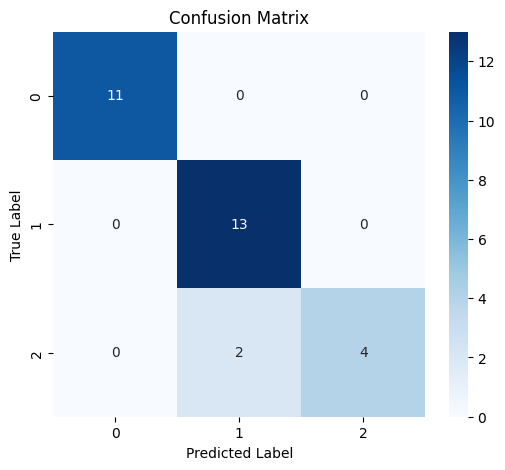

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def confusion_matrix(y_true, y_pred, labels=None):
    """
    Membuat confusion matrix dari label sebenarnya dan prediksi.
    :param y_true: List atau array label sebenarnya
    :param y_pred: List atau array label prediksi
    :param labels: List dari semua label unik (opsional)
    :return: Confusion matrix sebagai numpy array
    """
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    
    matrix = np.zeros((len(labels), len(labels)), dtype=int)
    label_to_index = {label: idx for idx, label in enumerate(labels)}
    
    for true, pred in zip(y_true, y_pred):
        matrix[label_to_index[true], label_to_index[pred]] += 1
    
    return matrix, labels

def plot_confusion_matrix(cm, labels):
    """
    Memvisualisasikan confusion matrix.
    :param cm: Confusion matrix dalam bentuk numpy array
    :param labels: Label kelas
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

cm, labels = confusion_matrix(y_test, test_preds)
print("Confusion Matrix:")
print(cm)
plot_confusion_matrix(cm, labels)